based on the original article 
https://courses.cs.washington.edu/courses/cse474/18wi/labs/l8/QRSdetection.pdf

In [2]:
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
from scipy import signal as sig
import numpy as np

In [3]:
#set main channel (usually there are 12)
mainChannel = 4

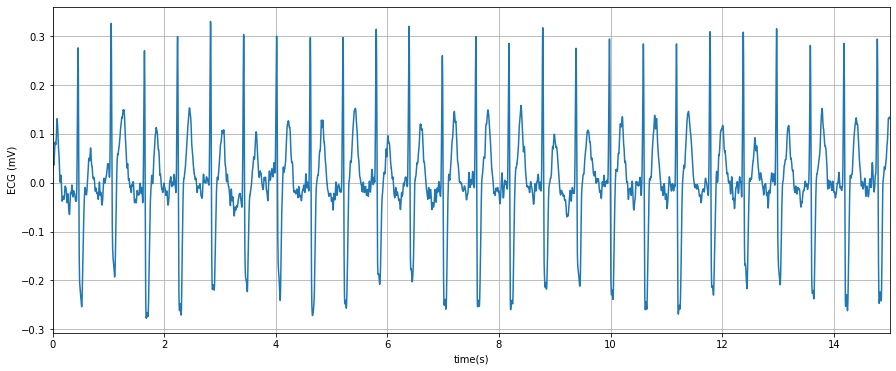

In [6]:
#read wfdbg file
record = wfdb.rdrecord('../read_data/A0001')
#save sampling frequency
fs = record.__dict__['fs']
#get data
data = record.__dict__['p_signal'][:,mainChannel]
N=len(data)
#create time array
time = np.linspace(0,len(data)-1,len(data))/fs
#get unit
unit = record.__dict__['units'][mainChannel]
#plot data
plt.figure(figsize=(15,6))
plt.plot(time,data)
plt.xlabel('time(s)');
plt.ylabel('ECG (' + unit+')');
plt.grid('both')
plt.autoscale(enable=True, axis='x', tight=True)

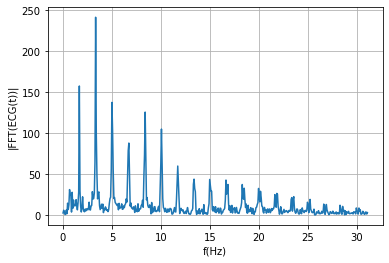

In [7]:
freq = np.linspace(0,fs-1,N)
plt.plot(freq[0:N//16],np.abs(np.fft.fft(data))[0:N//16])
plt.grid('both')
plt.xlabel('f(Hz)');
plt.ylabel('|FFT(ECG(t))|');

# Lowpass

In [8]:
N_view = fs*3 #number of samples to plot

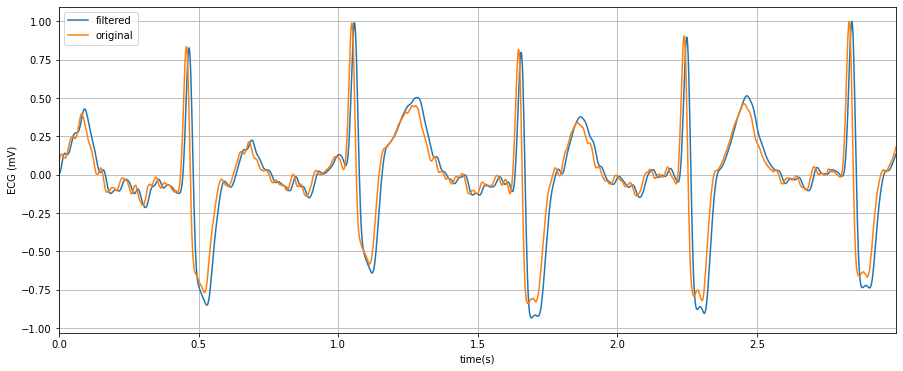

In [9]:
b=np.zeros(13)
b[0]=1
b[6]=-2
b[12]=1
a = np.array([1,-2,1])

sos_l = sig.tf2sos(b=b,a=a)

#apply filter
y1 = sig.sosfilt(sos_l,data)

#show orginal and filtered signals
plt.figure(figsize=(15,6))
plt.plot(time[:N_view],y1[:N_view]/max(y1),label='filtered')
plt.plot(time[:N_view],data[:N_view]/max(data),label='original')
plt.legend()
plt.xlabel('time(s)');
plt.ylabel('ECG (' + unit+')');
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid('both')

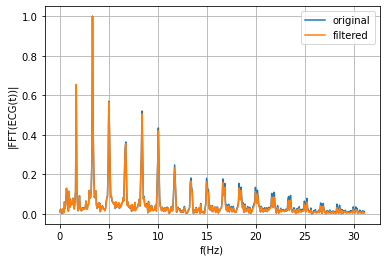

In [10]:
#show signal spectrum
fft_data = np.abs(np.fft.fft(data))
fft_filtered = np.abs(np.fft.fft(y1))
freq = np.linspace(0,fs-1,N)
plt.plot(freq[0:N//16],fft_data[0:N//16]/max(fft_data),label='original')
plt.plot(freq[0:N//16],fft_filtered[0:N//16]/max(fft_filtered),label='filtered')
plt.legend()
plt.grid('both')
plt.xlabel('f(Hz)');
plt.ylabel('|FFT(ECG(t))|');
plt.show()

# Highpass

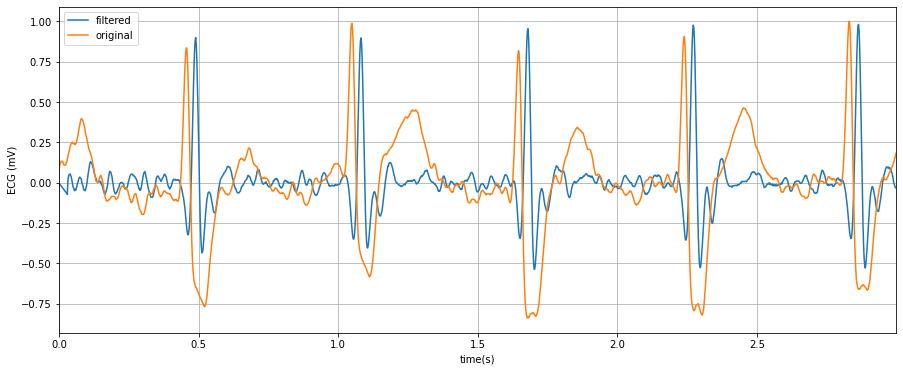

In [11]:
b=np.zeros(33)
b[0]=-1/32
b[16]=1
b[17]=-1
b[32] = 1/32 
a = np.array([1,-1])

sos_h = sig.tf2sos(b=b,a=a)

#apply filter
y1 = sig.sosfilt(sos_h,data)

#show orginal and filtered signals
plt.figure(figsize=(15,6))
plt.plot(time[:N_view],y1[:N_view]/max(y1),label='filtered')
plt.plot(time[:N_view],data[:N_view]/max(data),label='original')
plt.legend()
plt.xlabel('time(s)');
plt.ylabel('ECG (' + unit+')');
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid('both')

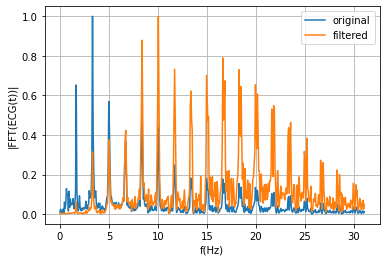

In [12]:
#show signal spectrum
fft_data = np.abs(np.fft.fft(data))
fft_filtered = np.abs(np.fft.fft(y1))
freq = np.linspace(0,fs-1,N)
plt.plot(freq[0:N//16],fft_data[0:N//16]/max(fft_data),label='original')
plt.plot(freq[0:N//16],fft_filtered[0:N//16]/max(fft_filtered),label='filtered')
plt.legend()
plt.grid('both')
plt.xlabel('f(Hz)');
plt.ylabel('|FFT(ECG(t))|');
plt.show()

# Bandpass

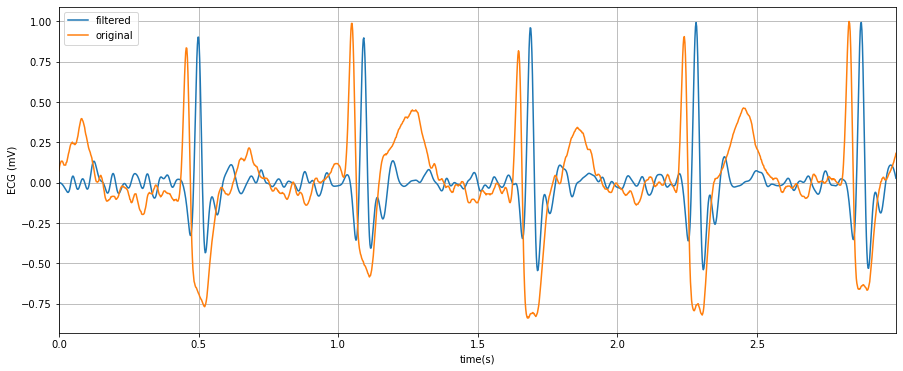

In [13]:
#bandpass filter using explicit low and high pass filters
y_l = sig.sosfilt(sos_l,data)
y_b = sig.sosfilt(sos_h,y_l)

plt.figure(figsize=(15,6))
plt.plot(time[:N_view],y_b[:N_view]/max(y_b),label='filtered')
plt.plot(time[:N_view],data[:N_view]/max(data),label='original')
plt.legend()
plt.xlabel('time(s)');
plt.ylabel('ECG (' + unit+')');
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid('both')

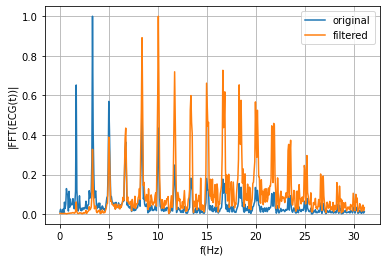

In [14]:
#show signal spectrum
fft_data = np.abs(np.fft.fft(data))
fft_filtered = np.abs(np.fft.fft(y_b))
freq = np.linspace(0,fs-1,N)
plt.plot(freq[0:N//16],fft_data[0:N//16]/max(fft_data),label='original')
plt.plot(freq[0:N//16],fft_filtered[0:N//16]/max(fft_filtered),label='filtered')
plt.legend()
plt.grid('both')
plt.xlabel('f(Hz)');
plt.ylabel('|FFT(ECG(t))|');
plt.show()

# Derivative

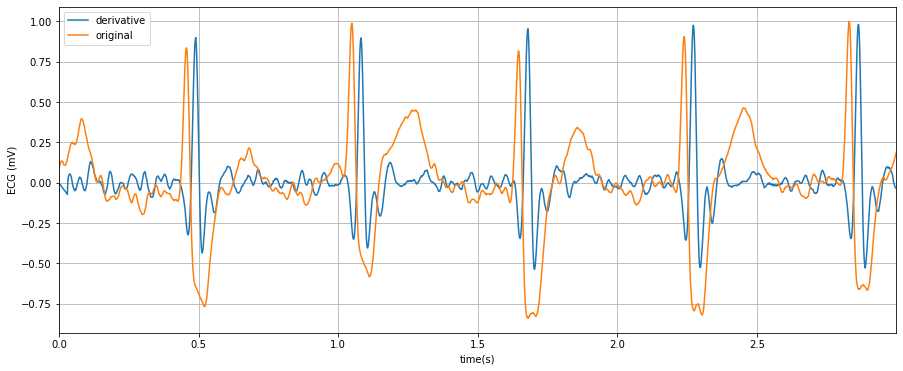

In [15]:
b=np.array([2,3,9,-1,-2])
b=b/8

a = 1

sos_d = sig.tf2sos(b=b,a=a)

#apply filter
y_d = sig.sosfilt(sos_h,data)

#show orginal and filtered signals
plt.figure(figsize=(15,6))
plt.plot(time[:N_view],y_d[:N_view]/max(y_d),label='derivative')
plt.plot(time[:N_view],data[:N_view]/max(data),label='original')
plt.legend()
plt.xlabel('time(s)');
plt.ylabel('ECG (' + unit+')');
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid('both')

# Power

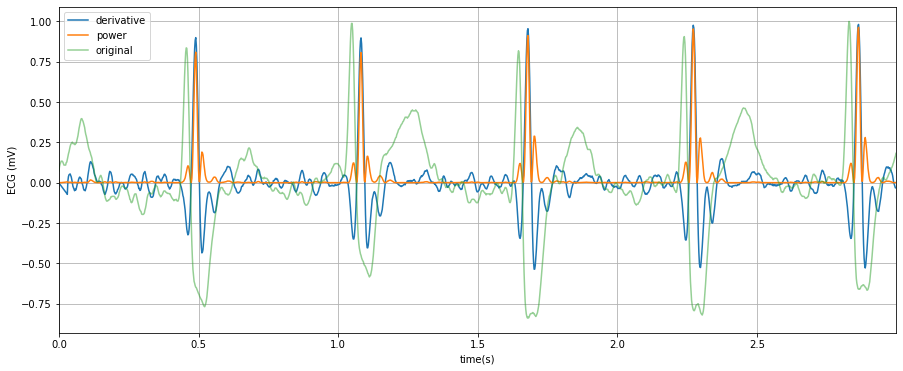

In [16]:
y_p = np.power(y_d,2)
plt.figure(figsize=(15,6))
plt.plot(time[:N_view],y_d[:N_view]/max(y_d),label='derivative')
plt.plot(time[:N_view],y_p[:N_view]/max(y_p),label='power')
plt.plot(time[:N_view],data[:N_view]/max(data),label='original',alpha=0.5)
plt.legend()
plt.xlabel('time(s)');
plt.ylabel('ECG (' + unit+')');
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid('both')

# Integration

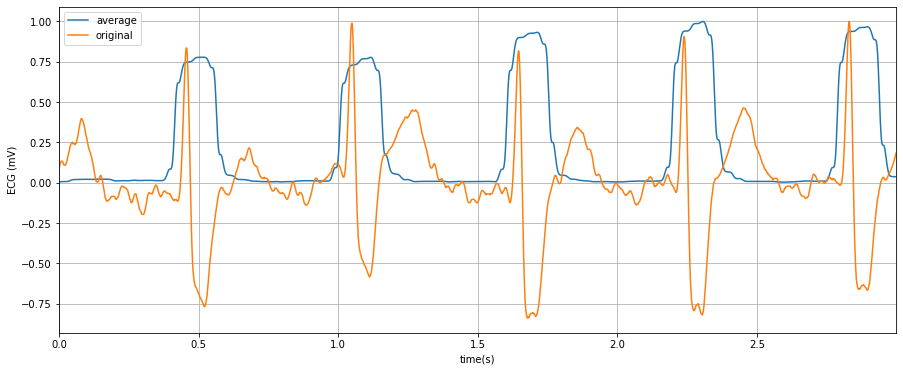

In [17]:
#average over 150ms, followind the original article
N_average = int(fs*0.15)
y_a = np.convolve(y_p,np.ones(N_average), 'same') / N_average
plt.figure(figsize=(15,6))
plt.plot(time[:N_view],y_a[:N_view]/max(y_a),label='average')
plt.plot(time[:N_view],data[:N_view]/max(data),label='original')
plt.legend()
plt.xlabel('time(s)');
plt.ylabel('ECG (' + unit+')');
plt.autoscale(enable=True, axis='x', tight=True)
plt.grid('both')

Text(0.5, 0, 'time (s)')

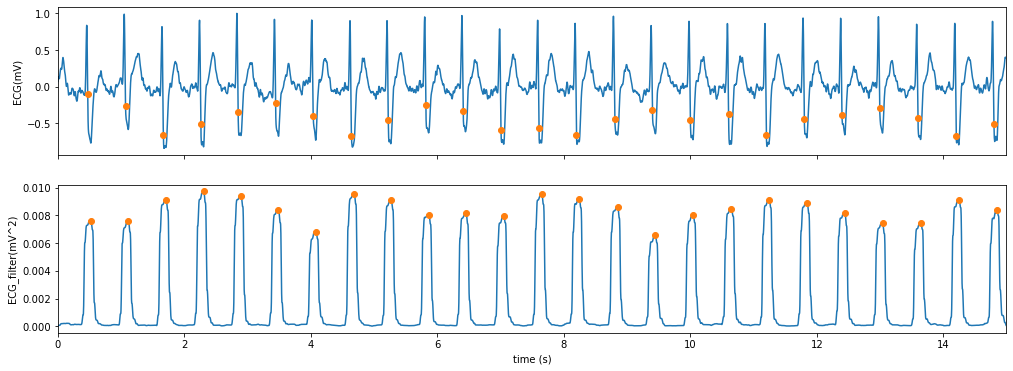

In [18]:
#threshold to find peaks
threshold = y_a.mean()+y_a.std()

#distance between peaks
maximumBPM = 200
distance = fs/(maximumBPM/60)

#find peaks indexes
peaks = sig.find_peaks(y_a,distance=distance,height=threshold)
fig, ax = plt.subplots(2,1,figsize=(17,6),sharex=True)
ax[0].plot(time,data/max(data))
ax[0].plot(time[peaks[0]-23], data[peaks[0]-23]/max(data), "o")
ax[0].autoscale(enable=True, axis='x', tight=True)
ax[0].set_ylabel('ECG(' + unit + ')')

ax[1].plot(time,y_a)
ax[1].plot(time[peaks[0]], y_a[peaks[0]], "o")
ax[1].autoscale(enable=True, axis='x', tight=True)
ax[1].set_ylabel('ECG_filter(' + unit + '^2)')
ax[1].set_xlabel('time (s)')

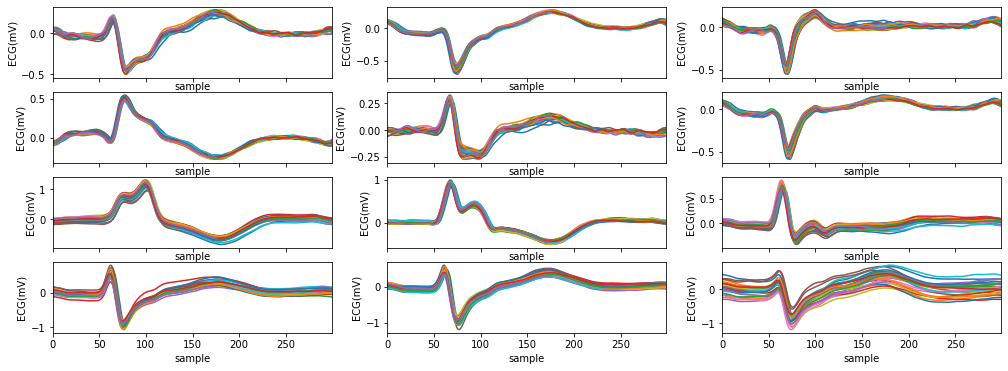

In [19]:
N_before = 100
N_after = 200
N_rows = 4
N_cols = 3
fig, axes = plt.subplots(N_rows,N_cols,figsize=(17,6),sharex=True, sharey=False)
for i in range(N_cols*N_rows):
    data_plot = record.__dict__['p_signal'][:,i]
    for p in peaks[0]:
        section = data_plot[-N_before+p:N_after+p]
        #section = section - section.mean()
        axes[i//N_cols][i%N_cols].plot(section)
        axes[i//N_cols][i%N_cols].set_ylabel('ECG(' + unit + ')')
        axes[i//N_cols][i%N_cols].set_xlabel('sample')
        axes[i//N_cols][i%N_cols].autoscale(enable=True, axis='x', tight=True)


# TODO: implement QRS according to the article  